In [1]:
import numpy as np
from tqdm.autonotebook import tqdm
import gym
import time
%matplotlib inline
import matplotlib.pyplot as plt

env = gym.make("CliffWalking-v0")
policy_to_action = {0:'L',1:'D',2:'R',3:'U'}

/home/aditya/.conda/envs/py3k/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/home/aditya/.conda/envs/py3k/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [2]:
GAMMA = 0.9

def epsilon_greedy(a,env,eps=0.1):
    p = np.random.random()
    if p < 1-eps: #exploit
        return a
    else: #explore
        return np.random.randint(0,env.nA)

In [3]:
def play_game(env,policy,EPSILON):
    s = env.reset()
    a = epsilon_greedy(policy[s],env,eps=EPSILON)
    
    #reward belong to one state and action before
    state_action_reward = [(s,a,0)]
    while True:
        s,r,terminated,_ = env.step(a)
        if terminated:
            state_action_reward.append((s,None,r))
            break
        else:
            a = epsilon_greedy(policy[s],env,eps=EPSILON)
            state_action_reward.append((s,a,r))
    G=0
    state_action_return = []
    first = True
    for s,a,r in reversed(state_action_reward):
        if first:
            first=False
        else:
            state_action_return.append((s,a,G))
            
        G = r + GAMMA*G
        state_action_return.reverse()
    return state_action_return

In [4]:
def monte_carlo(env,EPSILON=0.5,N_EPISODES=10000):
    policy = np.random.choice(env.nA,env.nS)
    
    Q = {}
    visit = {}
    for s in range(env.nS):
        Q[s] = {}
        visit[s] = {}
        for a in range(env.nA):
            Q[s][a] = 0
            visit[s][a] = 0
        
    deltas = [] #keep track of learning curve
    for i in tqdm(range(N_EPISODES),desc="Episodes Completed : ",leave=False):
        
        # epsilon decreasing
        esp = max( 0.1, EPSILON - i/N_EPISODES )
        
        state_action_return = play_game(env,policy,esp)
        seen_state_action = set()
        biggest_change = 0
        for s,a,G in state_action_return:
            if (s,a) not in seen_state_action:
                visit[s][a] += 1
                oldq = Q[s][a]
                #incremental mean
                Q[s][a] = Q[s][a] + ( G - Q[s][a] )/visit[s][a]
                seen_state_action.add((s,a))
                biggest_change = max( biggest_change , np.abs(oldq - Q[s][a]) )
        deltas.append(biggest_change)
        
        #update policy
        for s in Q.keys():
            best_a = None
            best_G = float('-inf')
            for a,G in Q[s].items():
                if G > best_G:
                    best_G = G
                    best_a = a
            policy[s] = best_a
    
    V = []
    for s in Q.keys():
        best_G = float('-inf')
        for _,G in Q[s].items():
            if G > best_G:
                best_G = G
        V.append(best_G)
        
    return V,policy,deltas

TIME TAKEN 3.69962739944458 seconds
Optimal Policy :
 [['D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'R' 'R']
 ['L' 'U' 'L' 'L' 'L' 'U' 'D' 'L' 'L' 'D' 'D' 'R']
 ['L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'D' 'R']
 ['L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L']] 
Optimal Values :
 [[-10.67512388 -10.63936957 -10.66033421 -10.64330446 -10.61002559
   -9.50827446  -9.62956982  -8.87735505  -8.10635744  -7.39902218
   -5.41334341  -8.6332385 ]
 [-11.34783495 -12.56723555 -12.15889066 -12.06805863 -12.44467464
  -16.05251844 -20.96631634 -12.11171645 -13.42464636 -10.67585445
   -4.60822475  -3.13008451]
 [-10.83744864 -18.37562518 -16.30524613 -14.89104288 -18.32040585
  -17.88696508 -28.47995961 -17.65686127 -20.3641596  -16.26212317
  -11.19243557  -1.        ]
 [-12.94485831   0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.           0.        ]]


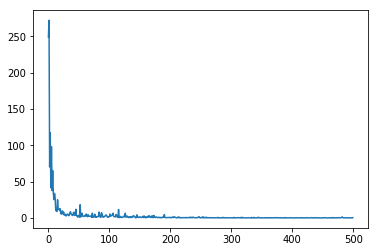

In [5]:
start = time.time()
value,policy,Delta = monte_carlo(env,EPSILON=.7,N_EPISODES=500)
print('TIME TAKEN {} seconds'.format(time.time()-start))

gpolicy = list(map(lambda a: policy_to_action[a],policy))
print("Optimal Policy :\n {} ".format(np.reshape(gpolicy,(4,12))))
print("Optimal Values :\n {}".format(np.reshape(value,(4,12))))

plt.plot(Delta)
plt.show()

In [6]:
"""
Lets see our success rate
"""
games = 1000
total_reward = 0
for _ in tqdm(range(games),desc="Games Played : "):
    state = env.reset()
    rewards = 0
    while True:
        action = int(policy[state])
        (state,reward,is_done,_) = env.step(action)
        rewards+=reward
        if is_done:
            total_reward+=rewards
            env.close()
            break
            
print("Success Rate : {}".format(total_reward/games))


Success Rate : -17.0
